In [1]:
# Cell 1: Loading CSV data from local file
!pip install pandas

import pandas as pd
books_csv = pd.read_csv('books.csv')
print("Initial CSV data:")
print(books_csv.head())

Initial CSV data:
                   title               author  publication_year
0       The Great Gatsby  F. Scott Fitzgerald              1925
1                   1984        George Orwell              1949
2  To Kill a Mockingbird           Harper Lee              1960


In [2]:
# Cell 2: Setting API key
%env OPENLIBRARY_API_KEY=your api key

env: OPENLIBRARY_API_KEY=your api key


In [3]:
# Cell 3: Getting API data
!pip install requests
import requests
import pandas as pd
import os


def get_book_details(title):
    OPENLIBRARY_API_KEY = os.environ['OPENLIBRARY_API_KEY']
    
    url = f"https://openlibrary.org/search.json?title={title}&apikey={OPENLIBRARY_API_KEY}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        if data['docs']:
            book = data['docs'][0]
            return {
                'isbn': book.get('isbn', ['N/A'])[0],
                'page_count': book.get('number_of_pages_median', 0),
                'first_publish': book.get('first_publish_year', None)
            }
    return {'isbn': 'N/A', 'page_count': 0, 'first_publish': None}

api_data = books_csv['title'].apply(get_book_details)
api_df = pd.DataFrame(api_data.tolist())
api_df

isbn  page_count  first_publish
0  N/A           0           1920
1  N/A           0           2003
2  N/A           0           1960

In [4]:
# Cell 4: Create and track dictionary data
book_categories = {
    "The Great Gatsby": {"genre": "Fiction", "rating": 4.5, "price": 12.99},
    "1984": {"genre": "Dystopian", "rating": 4.8, "price": 15.99},
    "To Kill a Mockingbird": {"genre": "Literary Fiction", "rating": 4.7, "price": 14.99}
}

category_df = pd.DataFrame.from_dict(book_categories, orient='index')
category_df.index.name = 'title'
category_df = category_df.reset_index()
category_df

title             genre  rating  price
0       The Great Gatsby           Fiction     4.5  12.99
1                   1984         Dystopian     4.8  15.99
2  To Kill a Mockingbird  Literary Fiction     4.7  14.99

In [5]:
# Cell 5: Combine datasets and perform transformations
from datetime import datetime

combined_df = pd.concat([books_csv, api_df], axis=1)
final_df = pd.merge(combined_df, category_df, on='title', how='left')

current_year = datetime.now().year
final_df['book_age'] = current_year - final_df['publication_year']
final_df['price_per_page'] = final_df['price'] / final_df['page_count'].replace(0, 1)

def rating_category(rating):
    if rating >= 4.5:
        return 'Excellent'
    elif rating >= 4.0:
        return 'Good'
    else:
        return 'Average'

final_df['rating_category'] = final_df['rating'].apply(rating_category)

<Figure size 1000x600 with 0 Axes>

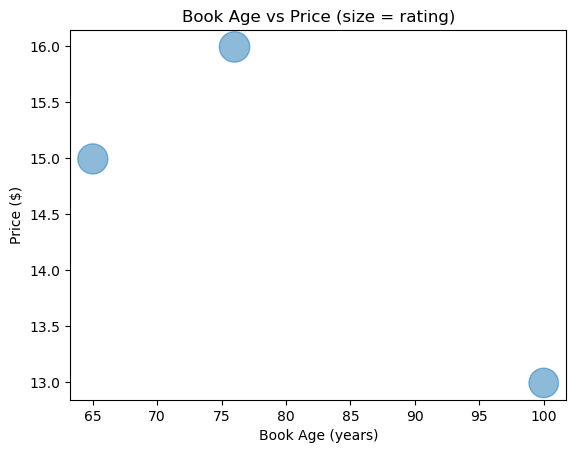

In [6]:
# Cell 6: Visualize results
genre_summary = final_df.groupby('genre').agg({
    'rating': 'mean',
    'price': 'mean',
    'page_count': 'mean'
}).round(2)
!pip install matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
final_df.plot(kind='scatter', x='book_age', y='price', s=final_df['rating']*100, alpha=0.5)
plt.title('Book Age vs Price (size = rating)')
plt.xlabel('Book Age (years)')
plt.ylabel('Price ($)')
plt.savefig("scatter_plot.png")
plt.show()